# Route Change Prediction - Advanced Analysis

This notebook focuses on understanding the feature importance, specifically temporal dynamics (lags), and handling class imbalance.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

from data_loader import load_data, parse_rtts_column
from feature_engineering import calculate_rtt_stats, add_temporal_features

## 1. Data Loading (Targeted Sample)
Loading a 2M row sample to allow for expensive sorting/grouping operations required for lag features.

In [2]:
SAMPLE_SIZE = 2000000
df = load_data('train.csv', sample_size=SAMPLE_SIZE)

Loading data from train.csv...
Loaded top 2000000 rows for development.


## 2. Advanced Feature Engineering
Calculating Lags, Diffs, Volatility and Spike Features.

In [3]:
df = parse_rtts_column(df)
df = calculate_rtt_stats(df)
df = add_temporal_features(df)

# Look at the new columns
print(df.columns)
display(df[['rtt_mean', 'volatility_rtt_mean', 'z_score_rtt']].head(10))

Parsing 'all_rtts' column...
Calculating RTT statistics (Vectorized)...
Generating temporal features (Lags, Rolling, Volatility)...
Index(['tr_id', 'tr_src', 'tr_dst', 'all_rtts', 'tr_attempts',
       'total_probes_sent', 'total_replies_last_hop', 'route_changed',
       'date_index', 'seconds_since_start', 'rtts_parsed', 'rtt_mean',
       'rtt_std', 'rtt_min', 'rtt_max', 'packet_loss_ratio', 'prev_rtt_mean',
       'diff_rtt_mean', 'prev_rtt_std', 'diff_rtt_std',
       'prev_packet_loss_ratio', 'diff_packet_loss_ratio', 'prev_seconds',
       'time_since_last', 'volatility_rtt_mean', 'rolling5_mean_rtt',
       'rolling5_std_rtt', 'z_score_rtt', 'packet_loss_trend'],
      dtype='object')


,rtt_mean,volatility_rtt_mean,z_score_rtt
0,210.087,NaN,NaN
1,210.087,0.0,0.0
2,210.087,0.0,0.0
3,210.087,0.0,0.0
4,210.087,0.0,0.0
5,210.087,0.0,0.0
6,210.087,0.0,0.0
7,210.087,0.0,0.0
8,210.087,0.0,0.0
9,210.087,0.0,0.0


## 3. Handling Class Imbalance (Undersampling)
The dataset is highly imbalanced. We will correct this for analysis by undersampling the majority class (No Change).

In [10]:
print("Original Distribution:")
print(df['route_changed'].value_counts())

# Separate classes
df_minority = df[df['route_changed'] == 1]
df_majority = df[df['route_changed'] == 0]

# Undersample majority
df_majority_downsampled = df_majority.sample(n=len(df_minority) * 2, random_state=42) # 1:2 Ratio

# Combine
df_balanced = pd.concat([df_minority, df_majority_downsampled])

print("\nBalanced Distribution (for Analysis):")
print(df_balanced['route_changed'].value_counts())

Original Distribution:
route_changed
0    1950465
1      49535
Name: count, dtype: int64

Balanced Distribution (for Analysis):
route_changed
0    99070
1    49535
Name: count, dtype: int64


## 4. Visualizing Feature Correlations (Volatility)

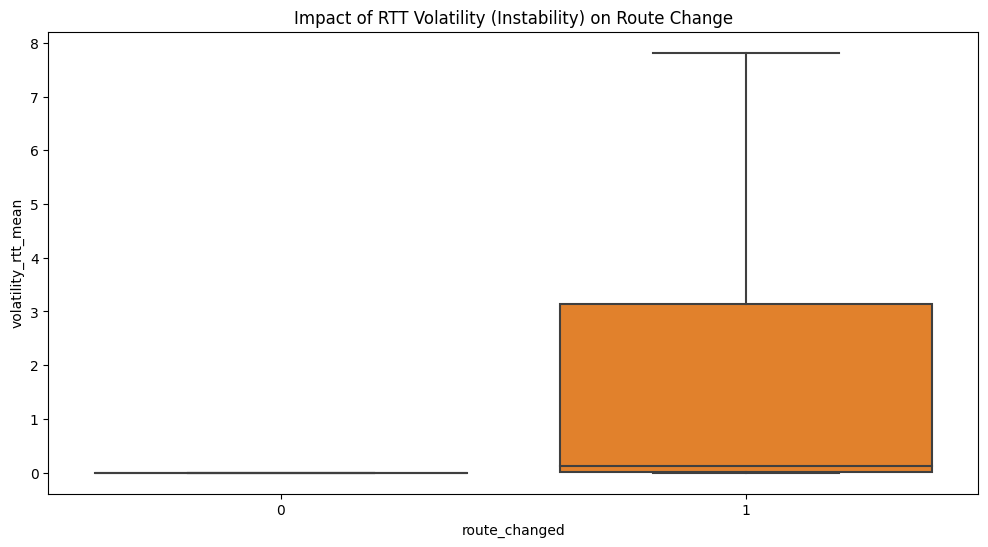

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='route_changed', y='volatility_rtt_mean', data=df_balanced, showfliers=False)
plt.title('Impact of RTT Volatility (Instability) on Route Change')
plt.show()

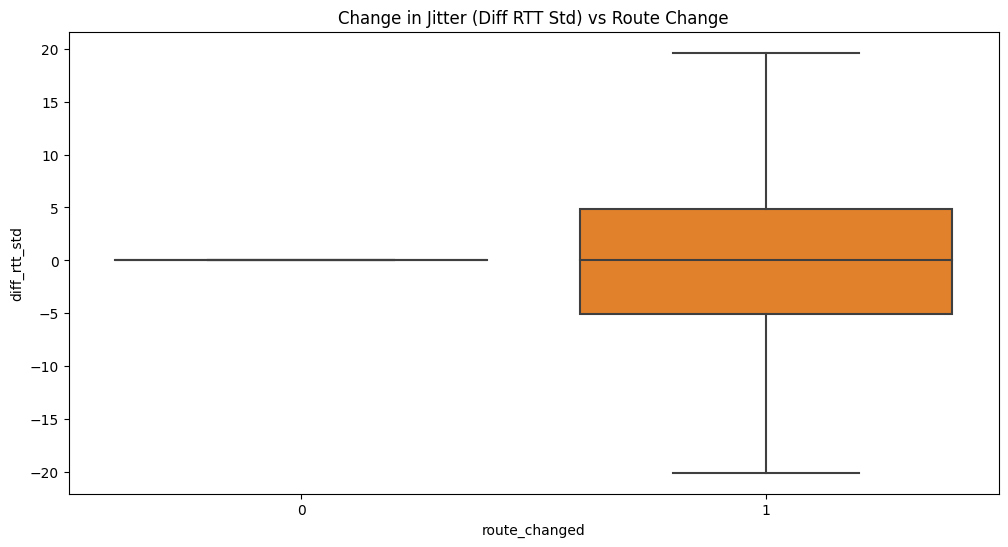

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='route_changed', y='diff_rtt_std', data=df_balanced, showfliers=False)
plt.title('Change in Jitter (Diff RTT Std) vs Route Change')
plt.show()

## 5. Model Training (Balanced)

In [13]:
features = [
    'rtt_mean', 'rtt_std', 'rtt_min', 'rtt_max', 'packet_loss_ratio',
    'prev_rtt_mean', 'prev_rtt_std', 'diff_rtt_mean', 'diff_rtt_std',
    'time_since_last', 'tr_attempts', 'total_probes_sent',
    'volatility_rtt_mean', 'z_score_rtt', 'packet_loss_trend'
]
target = 'route_changed'

# Use the balanced dataset for training to learn the signal better
df_model = df_balanced.dropna(subset=features)

X = df_model[features]
y = df_model[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Data: {X_train.shape}")

# Ensure data is clean (no infinite values from division)
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)

Training Data: (11034, 15)


In [14]:
clf = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.03, num_leaves=31, random_state=42)
clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(10)])

y_prob = clf.predict_proba(X_val)[:, 1]
y_pred = clf.predict(X_val)

print("ROC-AUC:", roc_auc_score(y_val, y_prob))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

[LightGBM] [Info] Number of positive: 2581, number of negative: 8453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2982
[LightGBM] [Info] Number of data points in the train set: 11034, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233913 -> initscore=-1.186344
[LightGBM] [Info] Start training from score -1.186344
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.0514687
ROC-AUC: 0.9956377930811936

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2114
           1       0.94      1.00      0.97       645

    accuracy                           0.98      2759
   macro avg       0.97      0.99  

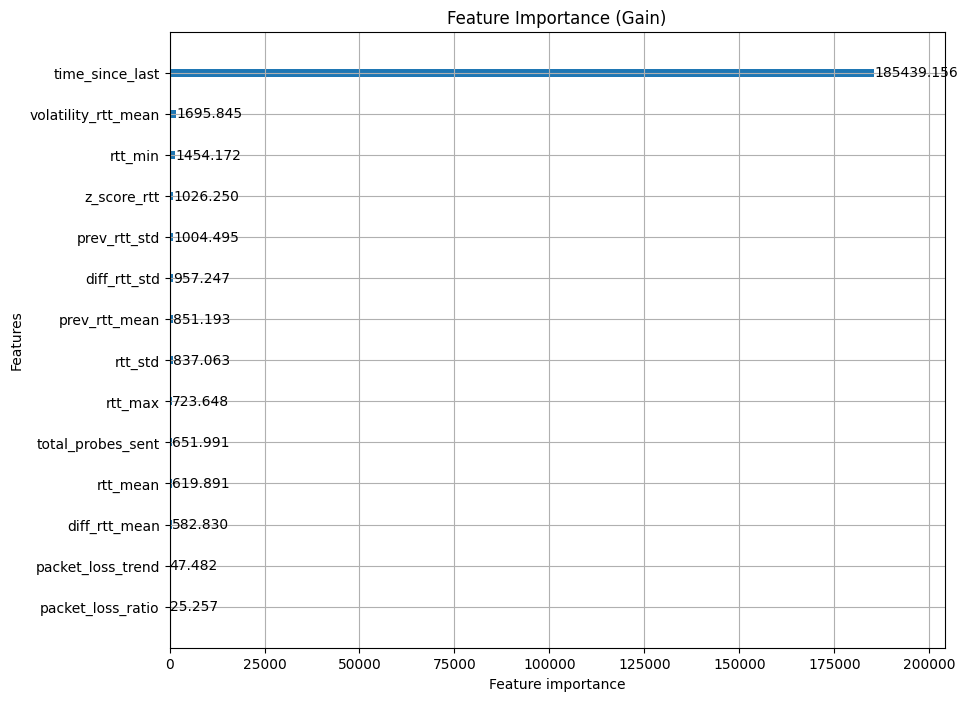

In [15]:
lgb.plot_importance(clf, importance_type='gain', figsize=(10, 8))
plt.title('Feature Importance (Gain)')
plt.show()